In [1]:
import os
from datetime import date, timedelta
from configparser import ConfigParser
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from PYOPATRA import *


In [2]:
# Configuration settings
# In hours
time_delta = 1
# Particle release per timedelta
num_particles = 10
# True particle release location
true_particle_lon = -88.365997
true_particle_lat = 28.736628
# Starting particle release location
particle_lon = -88.0
particle_lat = 28.6
prev_loc = np.array((particle_lat, particle_lon))
proposed_loc = np.array((particle_lat, particle_lon))
# Time elapsed
total_days = 8 * 7
total_time_steps = int(24 / time_delta * total_days) - 4
# When to add particles (time steps, not hours)
add_particles_time_step_interval = 3
# How frequently to save particles (time steps, not hours)
particle_save_interval = 3
# Number of Particles at the end
total_particles = (total_time_steps // add_particles_time_step_interval + 1) * num_particles
# Frame interval
frame_interval = 3
# For the Wasserstein investigation
num_to_try = 1000
obj_values = np.zeros(num_to_try)
num_proj = 100

times = ['000', '003', '006', '009', '012', '015', '018', '021']
start_date = date(2010, 4, 20)

In [3]:
hycom_files = []

for days_since_start in range(total_days):
    date = start_date + timedelta(days=days_since_start)

    for time_index, time_str in enumerate(times):
        file = 'data/hycom_gomu_501_{}{:02d}{:02d}00_t{}.nc'.format(date.year, date.month, date.day, time_str)
        hycom_files.append(file)

print('Reading HYCOM files....')
# Read HYCOM files
hfp = HYCOMFileParser()
hfp.read(hycom_files, diffusion_coefficient=10.0)

Reading HYCOM files....


In [4]:
print('Setting up mesh...')
# Set up 2D Triangular Mesh
tm2d = TriangularMesh2D()
tm2d.setup_mesh(hfp, 2)

Setting up mesh...
372600 187186 [90288. 90291. 90294. 90297. 90300. 90303. 90306. 90309. 90312. 90315.
 90318. 90321. 90324. 90327. 90330. 90333. 90336. 90339. 90342. 90345.
 90348. 90351. 90354. 90357. 90360. 90363. 90366. 90369. 90372. 90375.
 90378. 90381. 90384. 90387. 90390. 90393. 90396. 90399. 90402. 90405.
 90408. 90411. 90414. 90417. 90420. 90423. 90426. 90429. 90432. 90435.
 90438. 90441. 90444. 90447. 90450. 90453. 90456. 90459. 90462. 90465.
 90468. 90471. 90474. 90477. 90480. 90483. 90486. 90489. 90492. 90495.
 90498. 90501. 90504. 90507. 90510. 90513. 90516. 90519. 90522. 90525.
 90528. 90531. 90534. 90537. 90540. 90543. 90546. 90549. 90552. 90555.
 90558. 90561. 90564. 90567. 90570. 90573. 90576. 90579. 90582. 90585.
 90588. 90591. 90594. 90597. 90600. 90603. 90606. 90609. 90612. 90615.
 90618. 90621. 90624. 90627. 90630. 90633. 90636. 90639. 90642. 90645.
 90648. 90651. 90654. 90657. 90660. 90663. 90666. 90669. 90672. 90675.
 90678. 90681. 90684. 90687. 90690. 90693. 9

In [7]:
# Set up objective function
with h5py.File("data/observed_particles.hdf5", "r") as fp:
    obs_particles_temp = fp['particles'][:, :]

obs_particles = obs_particles_temp[~np.all(obs_particles_temp == 0, axis=1)]

In [8]:
print('Time stepping...')
current_num_particles = 0
frame = 0
# Time stepping
for i in range(total_time_steps):
    # print('Time step {}'.format(i))

    # Inject more particles
    if i % add_particles_time_step_interval == 0:
        for j in range(num_particles):
            tm2d.append_particle(proposed_loc)
            current_num_particles += 1

    tm2d.time_step(time_delta)

Time stepping...


In [18]:
obj_values = np.zeros((500, 10))

for i in range(1000, 10000, 1000):
    print(i)
    tm2d.setup_objective_function(obs_particles,
                              num_bins_lat_long=[700, 1000],
                              bounds=[hfp.latitude[0], hfp.latitude[-1], hfp.longitude[0], hfp.longitude[-1]],
                              num_proj=i)
    
    for j in range(500):
        if j % 100 == 0:
            print(j)
        obj_values[j, (i - 1000) // 1000] = tm2d.get_objective_value()
        

1000
0
100
200
300
400
2000
0
100
200
300
400
3000
0
100
200
300
400
4000
0
100
200
300
400
5000
0
100
200
300
400
6000
0
100
200
300
400
7000
0
100
200
300
400
8000
0
100
200
300
400
9000
0
100
200
300
400


In [19]:
np.save('obj_values.npy', obj_values)

In [24]:
ci = np.zeros((2, obj_values.shape[1]))

for i in range(obj_values.shape[1]-1):
    ci[:, i] = st.t.interval(0.95, obj_values.shape[0] - 1, loc=np.mean(obj_values[:, i]), scale=st.sem(obj_values[:, i]))

In [23]:
print(obj_values)

[[0.90631502 0.90087839 0.90838665 ... 0.89943442 0.90445793 0.        ]
 [0.9072769  0.89806819 0.90222165 ... 0.9008737  0.90456298 0.        ]
 [0.89700599 0.91184989 0.91350415 ... 0.90566043 0.90215478 0.        ]
 ...
 [0.89520621 0.90191557 0.90315213 ... 0.89989301 0.90650299 0.        ]
 [0.89713465 0.88808607 0.90667035 ... 0.90445002 0.90201392 0.        ]
 [0.89043894 0.90407693 0.90779063 ... 0.89760611 0.91110588 0.        ]]


In [25]:
print(ci)

[[0.90148393 0.90207185 0.9022008  0.90206005 0.9026187  0.90264527
  0.90223743 0.90231771 0.9022216  0.        ]
 [0.90298233 0.90312048 0.90303968 0.90277849 0.9032818  0.90328243
  0.90279606 0.90284593 0.90276503 0.        ]]


In [26]:
extremes = np.zeros((2, obj_values.shape[1] - 1))

In [27]:
for i in range(obj_values.shape[1] - 1):
    extremes[0, i] = np.max(obj_values[:, i])
    extremes[1, i] = np.min(obj_values[:, i])

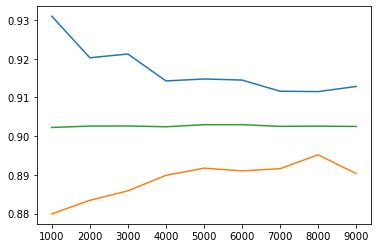

In [31]:
xvals = list(range(1000, 10000, 1000))

plt.plot(xvals, extremes[0, :])
plt.plot(xvals, extremes[1, :])
plt.plot(xvals, np.mean(obj_values[:, :-1], axis=0))